In [1]:
import sys
if 'google.colab' in sys.modules:
   !pip install koreanize_matplotlib konlpy gensim

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
from konlpy.tag import Okt
from gensim.models import Word2Vec
from collections import Counter

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Conv1D
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

In [4]:
df=pd.read_csv("./emergency_call_binary.csv", encoding="utf-8-sig")
df.head()


id                      document label
0   1    골목길에서 싸움이 났어요, 다친 사람이 있어요.    긴급
1   2       교통사고가 발생했는데 상대방이 도주했어요.    긴급
2   3       집 근처에서 폭죽 소리가 나고 시끄러워요.    경미
3   4  술집에서 손님끼리 다투고 있어요, 경찰이 필요해요.    긴급
4   5         차에 누가 돌을 던졌어요, 잡아주세요.    경미

In [4]:
padding_len = 32
embedding_dim = 1024

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['document'].apply(lambda x: ' '.join(x)))

sequences = tokenizer.texts_to_sequences(df['document'].apply(lambda x: ' '.join(x)))

X = pad_sequences(sequences, maxlen=padding_len, padding='post')

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df['label'])
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (300, 32), y shape: (300,)


In [6]:
vocab_size = len(tokenizer.word_index) + 1
print(f"vocab_size: {vocab_size}")
print(f"max index in sequences: {np.max(X)}")

vocab_size: 366
max index in sequences: 365


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

d1= 128
d2= 64

kernel_size = 3  # CNN 필터 크기
filters = 128    # CNN 필터 수

In [8]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padding_len),
    Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'),
    GlobalMaxPooling1D(),
    Dense(d1, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dense(d2, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [9]:
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_split=0.2, callbacks=[early_stop], verbose=1)


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.5340 - loss: 0.7512 - val_accuracy: 0.6667 - val_loss: 0.6664
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.7865 - loss: 0.5687 - val_accuracy: 0.7083 - val_loss: 0.5372
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9324 - loss: 0.2239 - val_accuracy: 0.8125 - val_loss: 0.4991
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9883 - loss: 0.0822 - val_accuracy: 0.8125 - val_loss: 0.5906
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9928 - loss: 0.0376 - val_accuracy: 0.7292 - val_loss: 1.1943
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9913 - loss: 0.0348 - val_accuracy: 0.7917 - val_loss: 1.1699
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 1.0000 - loss: 0.0148 - val_accuracy: 0.7917 - val_loss: 1.4579
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 1.0000 - loss: 0.0143 - val_accuracy: 0.7917 - val_loss: 1.

In [10]:
choice = 'cnn'

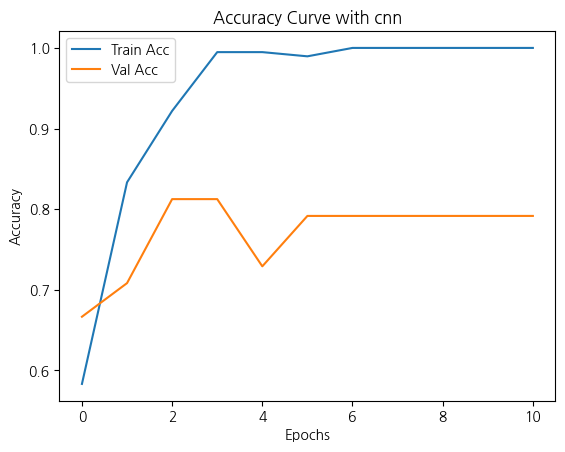

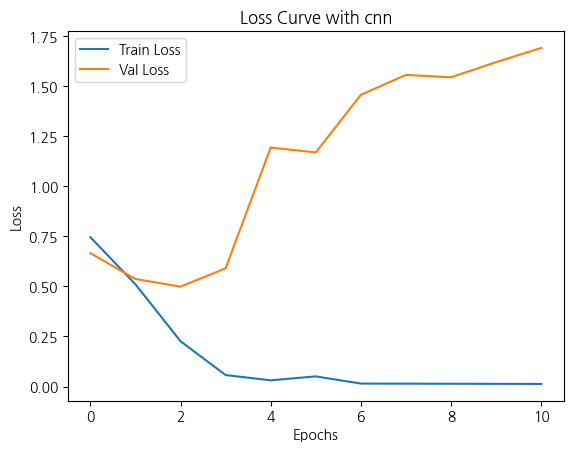

Test Accuracy of cnn: 0.7000, Loss: 0.9835


In [11]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title(f"Accuracy Curve with {choice}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f"Loss Curve with {choice}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 최종 평가
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy of {choice}: {acc:.4f}, Loss: {loss:.4f}")
